In [1]:
import json
import os
from PIL import Image
import torch
# Đường dẫn
json_path = "/mnt/VLAI_data/ViVQA-X/ViVQA-X_val.json"
coco_img_dir = "/mnt/VLAI_data/COCO_Images/val2014/"

# Đọc file JSON
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

samples = []
for item in data:
    img_path = os.path.join(coco_img_dir, item["image_name"])
    # Mở ảnh thành PIL Image
    image = Image.open(img_path).convert("RGB")
    sample = {
        "question": item["question"],
        "image": image,  # <-- PIL Image object
        "image_path": img_path,
        "explanation": item["explanation"],  # list
        "answer": item["answer"],
        "question_id": item["question_id"]
    }
    samples.append(sample)

# Kiểm tra 1 sample
print(samples[0])

{'question': 'Đây có phải là bức ảnh chụp nhiều độ phơi sáng của vận động viên trượt tuyết mặc áo đen không?', 'image': <PIL.Image.Image image mode=RGB size=640x480 at 0x7B03CF5FBE50>, 'image_path': '/mnt/VLAI_data/COCO_Images/val2014/COCO_val2014_000000393271.jpg', 'explanation': ['hình người mặc cùng một bộ quần áo khi trượt xuống dốc', 'có vẻ như là cùng một người trượt tuyết làm những pha nhào lộn khác nhau', 'cùng một người trượt tuyết xuất hiện nhiều lần'], 'answer': 'có', 'question_id': '393271001'}


In [2]:
SYSTEM_PROMPT_VIVQA_ENHANCED = (
    "<image>\nBạn là một trợ lý AI chuyên gia, có khả năng phân tích hình ảnh một cách cẩn thận và đa nghi. "
    "Nhiệm vụ của bạn là trả lời câu hỏi của người dùng dựa trên hình ảnh được cung cấp. "
    "Trước tiên, hãy thực hiện một chuỗi suy luận chi tiết bên trong cặp thẻ <thinking></thinking>. "
    "Sau khi hoàn tất quá trình suy luận, hãy cung cấp câu trả lời cuối cùng theo đúng định dạng yêu cầu.\n\n"
    "Câu hỏi: {question}\n\n"
    "ĐỊNH DẠNG BẮT BUỘC:\n"
    "<thinking>\n"
    "<SUMMARY>[Tóm tắt ngắn gọn về hình ảnh và yêu cầu của câu hỏi]</SUMMARY>\n"
    "<ANALYSIS>[Phân tích các chi tiết, vật thể, văn bản trong ảnh có liên quan trực tiếp đến câu hỏi. Liệt kê các bằng chứng quan sát được.]</ANALYSIS>\n"
    "<REASONING_STEPS>[Trình bày quá trình lập luận logic từng bước một. Từ các bằng chứng đã phân tích, làm thế nào để đi đến câu trả lời? Giải thích các mối liên hệ.]</REASONING_STEPS>\n"
    "<CONCLUSION>[Đưa ra kết luận cuối cùng từ quá trình lập luận trên.]</CONCLUSION>\n"
    "</thinking>\n"
    "<answer>[Điền câu trả lời trực tiếp và ngắn gọn vào đây]</answer>\n"
    "<explain>[Dựa vào quá trình suy luận trong <thinking>, giải thích cực kỳ ngắn gọn (trong khoảng 10-15 từ)]</explain>"
)

In [5]:
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM


model_id = "5CD-AI/Vintern-3B-R-beta"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
        pretrained_model_name_or_path=model_id,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
).eval().cuda()

`torch_dtype` is deprecated! Use `dtype` instead!


FlashAttention2 is not installed.


/opt/miniconda3/envs/minhtq-vqanle/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 44.00 MiB. GPU 0 has a total capacity of 23.67 GiB of which 43.31 MiB is free. Process 2687810 has 21.43 GiB memory in use. Including non-PyTorch memory, this process has 2.16 GiB memory in use. Of the allocated memory 1.90 GiB is allocated by PyTorch, and 58.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from transformers import AutoProcessor, AutoModelForImageTextToText
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

model_checkpoint = "5CD-AI/Vintern-3B-R-beta"
processor = AutoProcessor.from_pretrained(model_checkpoint, trust_remote_code=True)
model = AutoModelForImageTextToText.from_pretrained(model_checkpoint, device_map="auto", dtype=torch.bfloat16, trust_remote_code=True)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "http://images.cocodataset.org/val2017/000000039769.jpg"},
            {"type": "text", "text": "Please describe the image explicitly."},
        ],
    }
]

inputs = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt").to(model.device, dtype=torch.bfloat16)

generate_ids = model.generate(**inputs, max_new_tokens=50)
decoded_output = processor.decode(generate_ids[0, inputs["input_ids"].shape[1] :], skip_special_tokens=True)

decoded_output

ValueError: Unrecognized configuration class <class 'transformers_modules._5CD_hyphen_AI.Vintern_hyphen_3B_hyphen_R_hyphen_beta.4fd34d713dfca446cdecc00d921f5038909e3efb.configuration_internvl_chat.InternVLChatConfig'> for this kind of AutoModel: AutoModelForImageTextToText.
Model type should be one of AriaConfig, AyaVisionConfig, BlipConfig, Blip2Config, ChameleonConfig, Cohere2VisionConfig, DeepseekVLConfig, DeepseekVLHybridConfig, Emu3Config, EvollaConfig, Florence2Config, FuyuConfig, Gemma3Config, Gemma3nConfig, GitConfig, Glm4vConfig, Glm4vMoeConfig, GotOcr2Config, IdeficsConfig, Idefics2Config, Idefics3Config, InstructBlipConfig, InternVLConfig, JanusConfig, Kosmos2Config, Kosmos2_5Config, Lfm2VlConfig, Llama4Config, LlavaConfig, LlavaNextConfig, LlavaNextVideoConfig, LlavaOnevisionConfig, Mistral3Config, MllamaConfig, Ovis2Config, PaliGemmaConfig, PerceptionLMConfig, Pix2StructConfig, PixtralVisionConfig, Qwen2_5_VLConfig, Qwen2VLConfig, Qwen3VLConfig, Qwen3VLMoeConfig, ShieldGemma2Config, SmolVLMConfig, UdopConfig, VipLlavaConfig, VisionEncoderDecoderConfig.

In [2]:
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode

# Constants
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    """Build image transformation pipeline"""
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    """Find the closest aspect ratio from target ratios"""
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
                
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    """Dynamically preprocess image into multiple tiles"""
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height
    
    # Calculate target ratios
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) 
        for i in range(1, n + 1) 
        for j in range(1, n + 1) 
        if i * j <= max_num and i * j >= min_num
    )
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])
    
    # Find closest aspect ratio
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size
    )
    
    # Calculate target dimensions
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]
    
    # Resize and split image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    
    # Add thumbnail if needed
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
        
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    """Load and preprocess image"""
    if isinstance(image_file, str):
        image = Image.open(image_file).convert('RGB')
    else:
        image = image_file.convert('RGB')
    
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    
    return pixel_values

# # Generation config
# generation_config = dict(
#     max_new_tokens=1024, 
#     do_sample=False, 
#     num_beams=3, 
#     repetition_penalty=2.5
# )

# # Process your sample
# raw_image = samples[0]['image']
# question = samples[0]['question']

# # Load and preprocess image
# pixel_values = load_image(raw_image, max_num=6).to(torch.bfloat16).cuda()

# # Format question with image token
# final_prompt = f"<image>\n{question}"




# # 1) Lấy ID đúng của token ngữ cảnh ảnh
# img_ctx_id = tokenizer.convert_tokens_to_ids("<IMG_CONTEXT>")
# model.img_context_token_id = img_ctx_id
# assert model.img_context_token_id is not None

# # 2) Tính số token ảnh cần chèn
# num_patches = pixel_values.shape[0]  # số “ô”/ảnh sau dynamic preprocess của bạn
# num_img_tokens = model.num_image_token * num_patches  # thường là 256 * num_patches với cấu hình mặc định

# # 3) Xây image span và prompt
# image_span = "<img>" + "<IMG_CONTEXT>" * num_img_tokens + "</img>"
# prompt = f"<|im_start|>user\n{image_span}\n{question}<|im_end|>\n<|im_start|>assistant\n"

# # 4) Tokenize + cấu hình generate
# inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
# eos_id = tokenizer.convert_tokens_to_ids("<|im_end|>")
# gen_cfg = dict(
#     max_new_tokens=512,
#     do_sample=False,
#     num_beams=3,
#     repetition_penalty=1.1,
#     eos_token_id=eos_id,
#     pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
# )


In [ ]:
# Generate response using custom chat method (must model call AutoModel)
response, history = model.chat(
    tokenizer, 
    pixel_values, 
    final_prompt, 
    generation_config, 
    history=None, 
    return_history=True
)

print(f"User: {question}\nAssistant: {response}")

In [ ]:
# 5) Gọi generate (chú ý: KHÔNG cần image_flags; model tìm theo IMG_CONTEXT)
out = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    pixel_values=pixel_values,
    **gen_cfg
)

# 6) Decode
resp = tokenizer.decode(out[0], skip_special_tokens=True)
resp = resp.split("</s>")[0].split("<|im_end|>")[0].strip()  # gọn gàng lại nếu cần
print("Assistant:", resp)

In [ ]:
import torch

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
input_ids = inputs["input_ids"]
num_patches = pixel_values.shape[0]
image_flags = torch.ones((num_patches, 1), dtype=torch.long, device=model.device)
with torch.no_grad():
    out = model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        pixel_values=pixel_values,    
        image_flags=image_flags,     
        use_cache=False,                  
        return_dict=True
    )

logits = out.logits  # shape: [batch, seq_len, vocab_size]
logits

tensor([[[ 0.8789,  1.5703,  1.4922,  ..., -3.0312, -1.2812, -0.3125],
         [ 6.1562, 10.3750,  8.1875,  ..., -0.1475,  1.0703,  1.4297],
         [ 6.4688, 10.1250, 12.0000,  ..., -1.6406, -0.2715,  0.6562],
         ...,
         [ 0.8516, -3.7500,  0.0708,  ..., -3.9375, -1.6641, -0.9336],
         [11.0625,  7.1875, 15.2500,  ..., -1.4062, -1.1953,  0.7695],
         [ 4.6875, 10.8125,  8.6250,  ..., -4.0000, -2.5312, -1.5000]]],
       device='cuda:0', dtype=torch.bfloat16)

Loading model...


`torch_dtype` is deprecated! Use `dtype` instead!


FlashAttention2 is not installed.
Model loaded successfully!


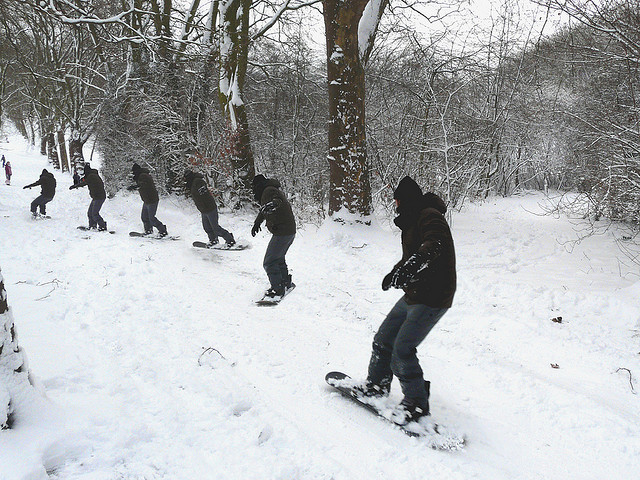


Generating response...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.



RESULTS

❓ Question: Đây có phải là bức ảnh chụp nhiều độ phơi sáng của vận động viên trượt tuyết mặc áo đen không?

✅ Ground Truth: có

🤖 Model Response:
Yes, the image shows several snowboarders wearing dark jackets and pants, which suggests they are using snowboards, indicating they are likely engaging in snowboarding activities. The snowboarders are also wearing helmets and goggles, which are typical safety gear for snowboarding. The presence of snow-covered trees and the snowy landscape further supports the idea that this is a winter sports setting.



In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
from PIL import Image
import json
from IPython.display import display
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# =========================
# 1. LOAD MODEL & TOKENIZER
# =========================
model_path = "OpenGVLab/InternVL3-1B"
print("Loading model...")
model = AutoModel.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
).cuda().eval()

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
print("Model loaded successfully!")

# =========================
# 2. LOAD TEST DATA
# =========================

image = samples[0]['image']
question = samples[0]['question']
ground_truth = samples[0]['answer']

display(image)



In [19]:
# =========================
# 3. PREPARE PROMPT (✅ Áp dụng Chat Template và Few-Shot)
# =========================
prompt = f"""You are an expert AI assistant for image analysis.
Your task is to answer questions based solely on the provided image. All of your responses MUST be in Vietnamese.

MANDATORY RULES:
Your response MUST strictly follow this exact 3-part format:
1. <thinking>: Step-by-step logical reasoning. </thinking>
2. <answer>: A single, CONCISE word or phrase. </answer>
3. <explain>: A SINGLE, succinct sentence for the explanation. </explain>

--- EXAMPLE ---
Question: What is the dominant color of the flower in the image?
RESPONSE:
<thinking>Phân tích hình ảnh cho thấy một bông hoa hướng dương với cánh hoa màu vàng rực rỡ và nhụy hoa màu nâu sẫm. Màu vàng là màu nổi bật và chiếm phần lớn diện tích của bông hoa.</thinking>
<answer>Màu vàng</answer>
<explain>Dựa vào hình ảnh, màu vàng tươi của bông hoa là đặc điểm chính và nổi bật nhất.</explain>
--- END OF EXAMPLE ---

Now, based on the provided image, answer the following question according to the rules above.

Question: {question}
RESPONSE:
"""


pixel_values = load_image(image, input_size=448, max_num=12).to(torch.bfloat16).cuda()

# =========================
# 4. GENERATE RESPONSE
# =========================
generation_config = {
    'max_new_tokens': 256,
    'do_sample': False,
    'num_beams': 1,
}

print("\nGenerating response...")
with torch.no_grad():
    response = model.chat(
        tokenizer,
        pixel_values,
        prompt,
        generation_config
    )

# =========================
# 5. DISPLAY RESULTS
# =========================
print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"\n❓ Question: {question}")
print(f"\n✅ Ground Truth: {ground_truth}")
print(f"\n🤖 Model Response:\n{response}")
print("\n" + "="*60)


Generating response...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.



RESULTS

❓ Question: Đây có phải là bức ảnh chụp nhiều độ phơi sáng của vận động viên trượt tuyết mặc áo đen không?

✅ Ground Truth: có

🤖 Model Response:
<th thinking> Trong bức ảnh, có thể thấy rõ ràng các vận động viên trượt tuyết đang di chuyển trên nền xanh của cây cối và trên nền xanh của bông hoa hướng dương. Điều này cho thấy có nhiều độ phơi sáng, vì các nhân vật mặc áo đen đang di chuyển trong không gian lạnh lẽo của một ngày trời có nhiều ánh sáng mặt trời.</thinking>
<answer>Đèn sáng</answer>
<explain> Các ánh sáng mặt trời chiếu xuống tạo ra nhiều độ phơi sáng, điều này cho thấy bức ảnh có thể được chụp vào một ngày trời có nhiều ánh sáng mặt trời.</explain>

